## Notes

- Low reduction quality on manifold curvature (at least for output, around 0.75 - 0.8)
- The cause of the low performance by the approximations was two things
	1. Hessian and Random reductions were being done by class, so that each class gets equal representation in the reduced dataset, while approximations were not
	2. More importantly, the datasize being passed to the approximation reduction algorithm was 1/10 the datasize for hessian and random
- Does Jacobian alone produce good results, or is there something special about the approximation
- May be good to show Jacobian reduction, output curv reduction, and approximation reduction all on the same graph
	- Hopefully, this would show that neither jacobian nor output curvature will reduce better than random, only the combination of the two

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax
import keras.utils as np_utils
import tensorflow as tf

from manifold_angles import ManifoldAngles

### Load Data

In [2]:
# with open('./cached/mnist_input_curv', 'rb') as file:
#   input_class_curvatures = pickle.load(file)
# with open('./cached/mnist_output_curv', 'rb') as file:
#   output_class_curvatures = pickle.load(file)

NUM_MODELS = 5
datasizes = np.logspace(3.7782, 2.47, 20).astype('int') * 10
datasizes

array([60000, 51200, 43700, 37290, 31820, 27160, 23170, 19780, 16880,
       14400, 12290, 10490,  8950,  7640,  6520,  5560,  4740,  4050,
        3450,  2950])

In [3]:
(X_train, train_y), (X_test, test_y) = mnist.load_data()

X_train: np.ndarray = X_train / 255
X_test: np.ndarray = X_test / 255

Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

### Define functions

In [4]:
def create_model():
	model = Sequential()
	model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='PReLU',use_bias=False, kernel_initializer='random_uniform', padding='valid'))
	model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
	model.add(Dense(10, activation='linear', kernel_initializer='random_uniform'))
	model.add(Softmax())
	return model

In [5]:
def shuffle_data(X: np.ndarray, Y: np.ndarray, seed: int):
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

In [6]:
def get_reduced_datasets(data_size: int, X: np.ndarray, Y: np.ndarray, order_method: str):
  _train_y = train_y

  _curvature_set = output_class_curvatures
	
  if order_method == 'random':
    keep_indices = np.random.choice(X.shape[0], data_size, replace=False)
    return X[keep_indices], Y[keep_indices]

  for y_class in range(10):
    class_indices = _train_y == y_class
    keep_indices = None
    if order_method == 'low_to_high':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[:data_size]
    elif order_method == 'high_to_low':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[-data_size:]
    elif order_method == 'extremes':
      return get_reduced_datasets_extremes(data_size, X, Y)
    elif order_method == 'mid':
      num_low_curv = data_size // 2
      num_high_curv = data_size - num_low_curv

      curv_midpoint = _curvature_set[y_class][:, 0].shape[0] // 2

      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[curv_midpoint - num_low_curv : curv_midpoint + num_high_curv]
    # elif order_method == 'ratio_low_to_high':
    #   ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
    #   keep_indices = np.argsort(ratios)[:data_size]
    # elif order_method == 'ratio_high_to_low':
    #   ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
    #   keep_indices = np.argsort(ratios)[-data_size:]
    else:
      raise ValueError(f"order method not implemented: {order_method}")

    new_x_row = X[class_indices][keep_indices]
    new_y_row = Y[class_indices][keep_indices]

    Reduced_X = np.vstack([Reduced_X, new_x_row]) if y_class > 0 else new_x_row
    Reduced_Y = np.vstack([Reduced_Y, new_y_row]) if y_class > 0 else new_y_row

  return Reduced_X, Reduced_Y

def get_reduced_datasets_extremes(data_size: int, X: np.ndarray, Y: np.ndarray, curvature_set='input'):
  _curvature_set = input_class_curvatures if curvature_set == 'input' else output_class_curvatures
  num_low_curv = data_size // 2
  num_high_curv = data_size - num_low_curv
  for y_class in range(10):
    class_indices = train_y == y_class
    argsorted_curvatures = np.argsort(_curvature_set[y_class][:, 0])
    low_curv_indices = argsorted_curvatures[:num_low_curv]
    high_curv_indices = argsorted_curvatures[-num_high_curv:]

    new_x_rows = np.vstack([X[class_indices][low_curv_indices], X[class_indices][high_curv_indices]])
    new_y_rows = np.vstack([Y[class_indices][low_curv_indices], Y[class_indices][high_curv_indices]])

    Reduced_X = np.vstack([Reduced_X, new_x_rows]) if y_class > 0 else new_x_rows
    Reduced_Y = np.vstack([Reduced_Y, new_y_rows]) if y_class > 0 else new_y_rows

  return Reduced_X, Reduced_Y

In [7]:
def get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', num_models=5, shuffle_seed=None):
  valacclist = []
  acclist = []
  for data_size in datasizes:
    Reduced_X_train, Reduced_Y_train = get_reduced_datasets(data_size, X_train, Y_train, order_method)
    print(f'ReducedX.shape: {Reduced_X_train.shape}')

    if shuffle_seed is not None:
      shuffle_data(Reduced_X_train, Reduced_Y_train, shuffle_seed)

    valacclist.append([])
    acclist.append([])
    for _ in range(num_models):
      _nt = create_model()
      _nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
      history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size = 128)
      del _nt
      print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
      valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
      acclist[-1].append(history.history['categorical_accuracy'][-1])
      del history

  return valacclist, acclist

In [8]:
def plot_accuracies(accuracies: list[float], names: list[str]=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(np.linspace(100, 100 * datasizes[-1] / datasizes[0], datasizes.shape[0]).round().astype('int'), np.mean(acclist, axis=1))

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xlabel('Percentage of Dataset Used in Training (%)')
  plt.ylabel(f'Average Model Test Accuracy (n={NUM_MODELS})')
  plt.grid()
  plt.gca().invert_xaxis()
  plt.show()

In [9]:
@tf.function
def get_hessian2(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
	with tf.GradientTape() as t2:
		t2.watch(input)
		with tf.GradientTape() as t1:
			t1.watch(input)
			loss = lossfunc(model(input),target)
		g=t1.gradient(loss,input)
	return t2.jacobian(g,input)

In [10]:
def jacobian(model, input, target, lossfunc=tf.keras.losses.CategoricalCrossentropy()):
	_input, _target = tf.convert_to_tensor(input), tf.convert_to_tensor(target)
	with tf.GradientTape() as tape:
		tape.watch(_input)
		out = model(_input)
		loss = lossfunc(out, _target)
		return np.array(tape.jacobian(loss, _input))

In [11]:
def flatten_output(labels, nested_curvs):
	'''flattens `nested_curvs` to the same order as `labels` e.g. turn output from [10, 5000] => [50000]'''
	out_flat = []
	visited = [0 for _ in range(10)]
	for label in labels:
		out_flat.append(nested_curvs[label][visited[label]])
		visited[label] += 1
	return np.squeeze(out_flat)

##### make model

In [16]:
nt = create_model()
nt.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history  = nt.fit(X_train, Y_train, epochs=25, validation_data=(X_test, Y_test), verbose=1, batch_size=128)
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")

Epoch 1/25
469/469 [==============================] - 1s 3ms/step - loss: 0.5603 - categorical_accuracy: 0.8624 - val_loss: 0.2790 - val_categorical_accuracy: 0.9206
Epoch 2/25
469/469 [==============================] - 1s 2ms/step - loss: 0.2450 - categorical_accuracy: 0.9305 - val_loss: 0.2037 - val_categorical_accuracy: 0.9420
Epoch 3/25
469/469 [==============================] - 1s 2ms/step - loss: 0.1800 - categorical_accuracy: 0.9485 - val_loss: 0.1606 - val_categorical_accuracy: 0.9538
Epoch 4/25
469/469 [==============================] - 1s 2ms/step - loss: 0.1426 - categorical_accuracy: 0.9590 - val_loss: 0.1388 - val_categorical_accuracy: 0.9600
Epoch 5/25
469/469 [==============================] - 1s 2ms/step - loss: 0.1199 - categorical_accuracy: 0.9651 - val_loss: 0.1234 - val_categorical_accuracy: 0.9636
Epoch 6/25
469/469 [==============================] - 1s 2ms/step - loss: 0.1025 - categorical_accuracy: 0.9700 - val_loss: 0.1148 - val_categorical_accuracy: 0.9665
Epoc

In [17]:
nt.save_weights('./temp/model_weights')
# nt = create_model()
# nt.load_weights('./temp/model_weights')

In [18]:
model_pre_softmax = tf.keras.Model(inputs=nt.input, outputs=nt.layers[-2].output)
predictions = model_pre_softmax(X_train)

##### generate output curvatures (no softmax)

In [15]:
output_curvatures = []
for y_class in range(10):
	print(f'     Generating curvature for class {y_class}...')
	class_predictions = predictions[train_y == y_class]
	# try inputs here
	_, manifold_neighbour_angle_sum = ManifoldAngles([class_predictions], classsize=1, neighboursize1=10, dim_reduc_size=5) # check if the reduction quality is low, if so raise numneighbors/reduction size
	output_curvatures.append(np.array(manifold_neighbour_angle_sum))
	del _, manifold_neighbour_angle_sum, class_predictions

     Generating curvature for class 0...
start: 
--layer time:  19.653648853302002


KeyboardInterrupt: 

In [ ]:
output_curvatures_flat = flatten_output(train_y, output_curvatures)
del output_curvatures

In [ ]:
# with open('./temp/mnist_output_curv_flat', 'rb') as file:
#   output_curvatures_flat = pickle.load(file)
with open('./temp/mnist_output_curv_flat', 'wb') as file:
  pickle.dump(output_curvatures_flat, file)

##### generate concatenated curvatures (input + output, no softmax) 

In [ ]:
# test mnist hessian reduction vs. approximation (output curvature based) vs concatenated approximation
# this code is also somewhere in bahadir's files he sent over, so try and find if necessary

lowersize = 20
s,u,v = tf.linalg.svd(X_train.reshape((X_train.shape[0], 28*28)))
layerdata = (u[:,:lowersize] * s[:lowersize]).numpy()
tf.print('layer quality: ', tf.norm(s[:lowersize]) / tf.norm(s))

# layerdata = batch size x 20 dimensional
reduced_input  = layerdata @ v[:lowersize,:]# or layerdata * v[:lowersize,:]
del s,u,v

layerfeatlist = [layerdata, predictions.numpy()]
print(layerdata.shape)
print(predictions.shape)
layerfeatlist = np.hstack(layerfeatlist)
print(layerfeatlist.shape)

concat_curvatures = []
for y_class in range(10):
	print(f'     Generating curvature for class {y_class}...')
	class_concats = layerfeatlist[train_y == y_class]
	# try inputs here
	_, manifold_neighbour_angle_sum = ManifoldAngles([class_concats], classsize=1, neighboursize1=10, dim_reduc_size=5) # check if the reduction quality is low, if so raise numneighbors/reduction size
	concat_curvatures.append(np.array(manifold_neighbour_angle_sum))
	del _, manifold_neighbour_angle_sum, class_concats

concat_curvatures_flat = flatten_output(train_y, concat_curvatures)
del concat_curvatures, predictions, layerfeatlist, layerdata
# send layer feat list to curvature calculation
# do this one, and also test MNIST with hessian reduction + approximation reduction

In [ ]:
# with open('./temp/mnist_concat_curv_flat', 'rb') as file:
#   concat_curvatures_flat = pickle.load(file)
with open('./temp/mnist_concat_curv_flat', 'wb') as file:
  pickle.dump(concat_curvatures_flat, file)

##### get jacobian norms of network per data point

In [19]:
jacobians = jacobian(nt, X_train, Y_train)
jacobian_norms = tf.norm(jacobians, axis=(1, 2))

In [20]:
# with open('./temp/jacobian_norms', 'rb') as file:
#   jacobian_norms = pickle.load(file)
with open('./temp/jacobian_norms', 'wb') as file:
  pickle.dump(jacobian_norms, file)

##### get hessian norm of network per data point

In [ ]:
Heslist = []
lossfunc = tf.keras.losses.CategoricalCrossentropy()
for i in range(X_train.shape[0]):
	print(f'{i}/{X_train.shape[0]+1}')
	Heslist.append(np.linalg.norm(get_hessian2(nt,X_train[i:i+1],Y_train[i:i+1],lossfunc=lossfunc)[0]))

Heslist = np.array(Heslist)

In [ ]:
# with open('./temp/heslist', 'rb') as file:
#   Heslist = pickle.load(file)
with open('./temp/heslist', 'wb') as file:
  pickle.dump(Heslist, file)

##### reduce dataset by OUTPUT based hessian norm approximation

In [ ]:
out_approx_valacclist = []
for data_size in datasizes:
	approximations = output_curvatures_flat * jacobian_norms
	keep_indices = np.argsort(approximations)[-data_size:]
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	out_approx_valacclist.append([])
	for _ in range(NUM_MODELS):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size=128)
		del _nt
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		out_approx_valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
		del history

ReducedX.shape: (60000, 28, 28)
  train acc = 0.9921666383743286 val acc = 0.9742000102996826
  train acc = 0.9926499724388123 val acc = 0.9735000133514404
  train acc = 0.9928500056266785 val acc = 0.9739000201225281
  train acc = 0.9926000237464905 val acc = 0.9696999788284302
  train acc = 0.9925500154495239 val acc = 0.9724000096321106
ReducedX.shape: (54590, 28, 28)
  train acc = 0.9914636611938477 val acc = 0.9735999703407288
  train acc = 0.991848349571228 val acc = 0.9751999974250793
  train acc = 0.9902362823486328 val acc = 0.9718999862670898
  train acc = 0.9908957481384277 val acc = 0.9714999794960022
  train acc = 0.9914819598197937 val acc = 0.9713000059127808
ReducedX.shape: (49670, 28, 28)
  train acc = 0.988182008266449 val acc = 0.9690999984741211
  train acc = 0.9881216287612915 val acc = 0.9724000096321106
  train acc = 0.989832878112793 val acc = 0.9745000004768372
  train acc = 0.986349880695343 val acc = 0.9710999727249146
  train acc = 0.9888262748718262 val acc

##### reduce dataset by CONCATENATION based hessian norm approximation

In [ ]:
concat_approx_valacclist = []
for data_size in datasizes:
	approximations = concat_curvatures_flat * jacobian_norms
	keep_indices = np.argsort(approximations)[-data_size:]
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	concat_approx_valacclist.append([])
	for _ in range(NUM_MODELS):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size=128)
		del _nt
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		concat_approx_valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
		del history

ReducedX.shape: (60000, 28, 28)
  train acc = 0.9928833246231079 val acc = 0.973800003528595
  train acc = 0.9933333396911621 val acc = 0.9714999794960022
  train acc = 0.9923166632652283 val acc = 0.9735999703407288
  train acc = 0.993149995803833 val acc = 0.9724000096321106
  train acc = 0.9928833246231079 val acc = 0.9751999974250793
ReducedX.shape: (54590, 28, 28)
  train acc = 0.9917567372322083 val acc = 0.973800003528595
  train acc = 0.99245285987854 val acc = 0.9715999960899353
  train acc = 0.9919765591621399 val acc = 0.9735000133514404
  train acc = 0.9915918707847595 val acc = 0.9736999869346619
  train acc = 0.990034818649292 val acc = 0.9714999794960022
ReducedX.shape: (49670, 28, 28)
  train acc = 0.9899939894676208 val acc = 0.9739999771118164
  train acc = 0.9880813360214233 val acc = 0.9711999893188477
  train acc = 0.9897523522377014 val acc = 0.973800003528595
  train acc = 0.9908193945884705 val acc = 0.9742000102996826
  train acc = 0.9903764724731445 val acc = 

##### reduce dataset by ACTUAL hessian norm

In [ ]:
hess_val_acc= []
for datasize in datasizes:
	keep_indices = np.argsort(Heslist)[-datasize:]
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	hess_val_acc.append([])
	for i in range(NUM_MODELS):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size=128)
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		del _nt
		hess_val_acc[-1].append(history.history['val_categorical_accuracy'][-1])

ReducedX.shape: (60000, 28, 28)
  train acc = 0.9926666617393494 val acc = 0.972599983215332
  train acc = 0.9924833178520203 val acc = 0.9739999771118164
  train acc = 0.9930499792098999 val acc = 0.9722999930381775
  train acc = 0.9922333359718323 val acc = 0.9713000059127808
  train acc = 0.992900013923645 val acc = 0.9750000238418579
ReducedX.shape: (54590, 28, 28)
  train acc = 0.990034818649292 val acc = 0.9742000102996826
  train acc = 0.9923795461654663 val acc = 0.9740999937057495
  train acc = 0.9910606145858765 val acc = 0.9696000218391418
  train acc = 0.9921414256095886 val acc = 0.9751999974250793
  train acc = 0.9912071824073792 val acc = 0.9728000164031982
ReducedX.shape: (49670, 28, 28)
  train acc = 0.990295946598053 val acc = 0.9735999703407288
  train acc = 0.989389955997467 val acc = 0.972599983215332
  train acc = 0.9887658357620239 val acc = 0.97079998254776
  train acc = 0.9900745153427124 val acc = 0.9702000021934509
  train acc = 0.9909603595733643 val acc = 0

##### reduce dataset by Jacobian norm

In [ ]:
jac_val_acc= []
for datasize in datasizes:
	keep_indices = np.argsort(jacobian_norms)[-datasize:]
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	jac_val_acc.append([])
	for i in range(NUM_MODELS):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size=128)
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		del _nt
		jac_val_acc[-1].append(history.history['val_categorical_accuracy'][-1])

ReducedX.shape: (60000, 28, 28)
  train acc = 0.9917833209037781 val acc = 0.9731000065803528
  train acc = 0.9932666420936584 val acc = 0.9736999869346619
  train acc = 0.9927666783332825 val acc = 0.972000002861023
  train acc = 0.9926999807357788 val acc = 0.9732999801635742
  train acc = 0.9930833578109741 val acc = 0.9722999930381775
ReducedX.shape: (54590, 28, 28)
  train acc = 0.9899615049362183 val acc = 0.972100019454956
  train acc = 0.9930390119552612 val acc = 0.9745000004768372
  train acc = 0.9910972714424133 val acc = 0.9745000004768372
  train acc = 0.9891921877861023 val acc = 0.9732000231742859
  train acc = 0.9909873604774475 val acc = 0.9735000133514404
ReducedX.shape: (49670, 28, 28)
  train acc = 0.9891080856323242 val acc = 0.9710999727249146
  train acc = 0.9903160929679871 val acc = 0.9711999893188477
  train acc = 0.9900745153427124 val acc = 0.9753000140190125
  train acc = 0.9886853098869324 val acc = 0.974399983882904
  train acc = 0.9900543689727783 val ac

##### reduce dataset randomly

In [ ]:
random_val_acc = []
for data_size in datasizes:
	keep_indices = np.random.choice(X_train.shape[0], data_size, replace=False)
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	random_val_acc.append([])
	for _ in range(NUM_MODELS):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size=128)
		del _nt
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		random_val_acc[-1].append(history.history['val_categorical_accuracy'][-1])
		del history

### Dataset is reduced by keeping HIGHEST n% of dataset based on given metric

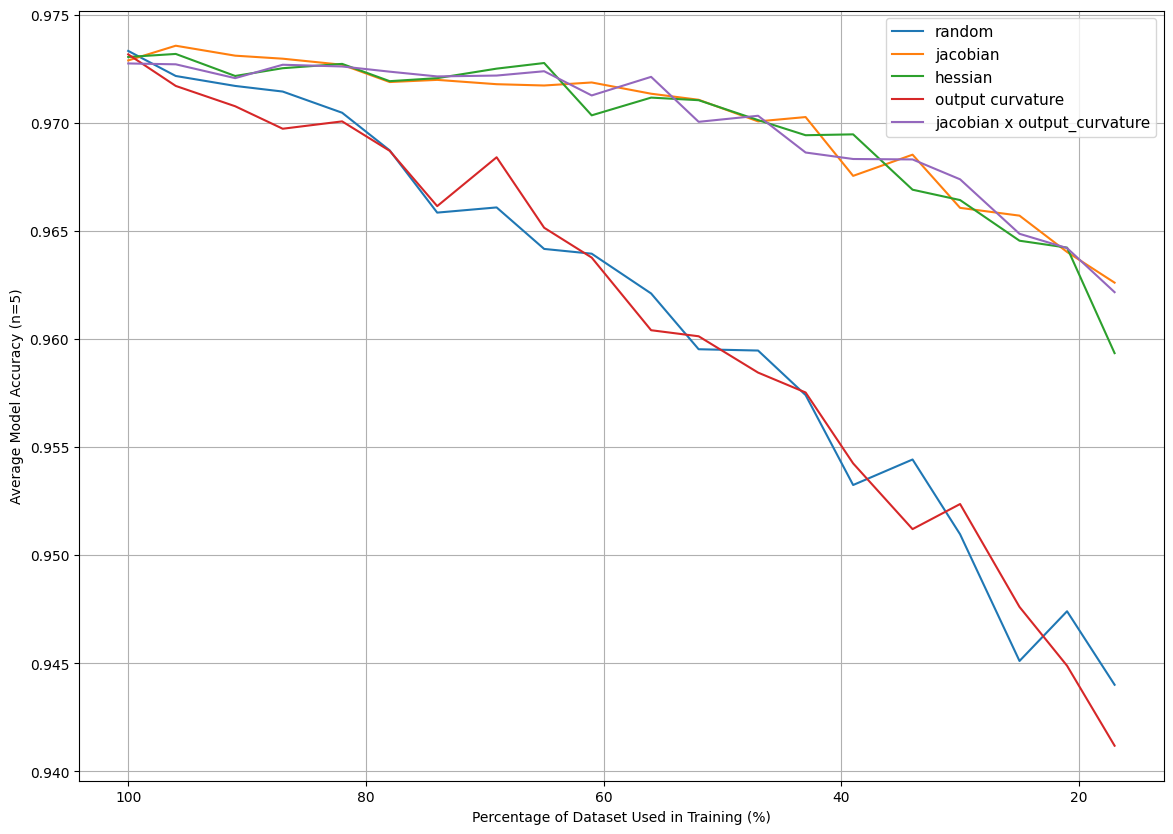

In [ ]:
plot_accuracies([random_val_acc, jac_val_acc], names=['random', 'jacobian'])